In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
from datetime import timedelta

import matplotlib.pyplot as plt
from matplotlib.font_manager import FontProperties
import matplotlib.pylab as pylab
#%matplotlib inline

from os import listdir
from os.path import isfile, join

import os
import imageio

In [5]:
# get data from github
url = 'https://raw.githubusercontent.com/tyler-martin-12/rowing_hr_training/master/jun_6_data.csv'
df_raw = pd.read_csv(url)
df_raw.head()

,day,date,distance,time,hr,rate,pace
0,Tuesday,1/1/2019,10253,45,158.0,19,131.7
1,Tuesday,1/1/2019,10227,45,158.0,19,132.0
2,Wednesday,1/2/2019,10274,45,159.0,19,131.4
3,Thursday,1/3/2019,10274,45,159.0,19,131.4
4,Saturday,1/5/2019,10119,45,154.0,19,133.4


In [6]:
# clean data
# only time = 45 min
df = df_raw[df_raw['time'] == 45]

# drop rows where hr = Nan
df = df.copy().dropna()

In [13]:
# define some functions

# convert string to date
def str_to_date(string):
    x = datetime.strptime(string, '%m/%d/%Y')
    return datetime.date(x)

# convert datetime object to string
def date_to_str(this_dt):
    x = datetime.strftime(this_dt, '%m/%d/%Y')
    return x

# get list of alphas (transparency) for plot
def get_alpha(df,num_to_highlight):
    df_len = len(df)
    column = np.ones(df_len) * .2
    if num_to_highlight > 0:
        column[-num_to_highlight:] = 1
    return column

# returns all of the files from a directory
def files_from_dir(a_dir):
    onlyfiles = [f for f in listdir(a_dir) if isfile(join(a_dir, f))]
    return onlyfiles

In [14]:
# add a column with a datetime object
df['datetime'] = pd.Series([str_to_date(d) for d in df['date']]).values

# add a column with a date string with a specific format (01/01/2019)
df['date_string'] = df['datetime'].apply(date_to_str)

In [15]:
df.head()

,day,date,distance,time,hr,rate,pace,datetime,date_string
0,Tuesday,1/1/2019,10253,45,158.0,19,131.7,2019-01-01,01/01/2019
1,Tuesday,1/1/2019,10227,45,158.0,19,132.0,2019-01-01,01/01/2019
2,Wednesday,1/2/2019,10274,45,159.0,19,131.4,2019-01-02,01/02/2019
3,Thursday,1/3/2019,10274,45,159.0,19,131.4,2019-01-03,01/03/2019
4,Saturday,1/5/2019,10119,45,154.0,19,133.4,2019-01-05,01/05/2019


In [16]:
# distance (meters) is recorded but I want to plot according to watts
# https://www.concept2.com/indoor-rowers/training/calculators/watts-calculator
df['split'] = 45*60/(df['distance']/500)
df['watts'] = 2.8 / (df['split']/500)**3

In [ ]:
w = np.linspace(145,200)
w = np.linspace(1,500)

In [25]:
distance_ticks_str = ['10,200','10,400','10,600','10,800','11,000','11,200']
distance_ticks = np.array([10200,10400,10600,10800,11000,11200])
splits = 45 * 60 * 500 / distance_ticks
watts_ticks = 2.8/((splits/500)**3)

In [29]:
def make_plot(df,idx,num_to_highlight, date_string):
    plt.ioff()
    
    # data for plot
    df_trunc = df[:idx]

    x = df_trunc['watts']
    y = df_trunc['hr']
    
    data_len = len(df_trunc['hr'])
    
    alphas = get_alpha(df_trunc,num_to_highlight)
    
    rgba_colors = np.zeros((data_len,4))
    rgba_colors[:,0] = 1.0
    rgba_colors[:, 3] = alphas
    
    # plot
    #fig = plt.figure()
    fig, ax1 = plt.subplots()
    ax1.scatter(x, y, color=rgba_colors)

    ax1.set_ylim([146,164])
    ax1.set_ylabel('Average Heart Rate')

    ax1.set_xlim([145,200])
    ax1.set_xlabel('Average Watts in 45 min')
    
    ax2 = ax1.twiny()
    ax2.set_xlabel('Meters in 45 min')
    ax2.set_xlim(145, 200)
    ax2.set_xticks(watts_ticks)
    ax2.set_xticklabels(distance_ticks_str)
    ax2.grid(True)
    
    ax1.set_title('Heart rate and power over time (rowing)')
    ax1.yaxis.grid(which='major')


    plt.rcParams['axes.facecolor'] = 'white'
    plt.rcParams['axes.edgecolor'] = 'black'
    plt.rcParams['grid.alpha'] = 1
    plt.rcParams['grid.color'] = "#cccccc"
    plt.grid(True)

    params = {'axes.titlesize': 'xx-large',
             'legend.fontsize': 'large',
             'figure.figsize': (15, 5),
             'axes.labelsize': 'large',
             'xtick.labelsize':'large',
             'ytick.labelsize':'large'}

    pylab.rcParams.update(params)
    
    
    textstr = date_string
    props = dict(boxstyle='round', facecolor='wheat', alpha=1)

    # place a text box in upper left in axes coords
    ax1.text(-0.1, 1.1, textstr, transform=ax1.transAxes, fontsize=11,
            verticalalignment='top', bbox=props)
    
    plt.subplots_adjust(top=0.85)     # Add space at top
    this_fig = plt.gcf()
    ax = plt.gca()
    ax.grid(True)
    this_fig.set_size_inches(8, 5)
    return this_fig

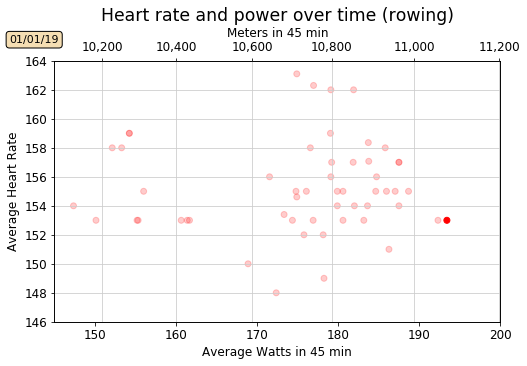

In [55]:
# testing the make_plot function
idx = 54
make_plot(df,idx,1,'01/01/19')

In [52]:
start_date = df['datetime'].iloc[0]

idx = 0

fig_count = 1

# 156 days in the training period
# let's make one images for each day
for days in range(156):
    this_date = start_date + timedelta(days=days)
    
    num_to_highlight = sum(df['datetime']==this_date)
    
    date_string = date_to_str(this_date)
    
    idx += num_to_highlight 
    
    fig = make_plot(df,idx,num_to_highlight,date_string)
      
    fig.savefig(f'for_gif/{fig_count:03d}.png', dpi=200)
    plt.close(fig)
    
    fig_count += 1
    

# generate a static plot of the final frame
this_date = start_date + timedelta(days=155)
num_to_highlight = sum(df['datetime']==this_date)
date_string = date_to_str(this_date)
fig = make_plot(df,idx,num_to_highlight,date_string)

# so that the final frame will be displayed shortly before the gif restarts
for extra in range(10):
    fig.savefig(f'for_gif/{fig_count:03d}.png', dpi=200)
    plt.close(fig)
    
    fig_count += 1


In [53]:
# get files names
file_list = files_from_dir('for_gif/')
file_list.sort()

# make gif from images
images = []
for file in file_list:
    path = os.path.join('for_gif/',file)
    images.append(imageio.imread(path))

imageio.mimsave('rowing_training.gif', images)